Libraries used

In [ ]:
pip install random-walk-controversy

In [ ]:
pip install langdetect

In [ ]:
!pip install vaderSentiment

In [ ]:
!pip install bertopic pandas

In [ ]:
pip install cdlib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
import tarfile
import subprocess
import pandas as pd
from sklearn.model_selection import train_test_split
import csv
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')
import numpy as np
import networkx as nx
import random
from langdetect import detect
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import networkx as nx
from cdlib.algorithms import eva
from networkx.algorithms.components.connected import connected_components
from random_walk_controversy import get_rwc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#How to download METIS
tarball_path = "/content/drive/MyDrive/Tesi Magistrale/metis-5.1.0.tar.gz"
with tarfile.open(tarball_path, "r:gz") as tar:
    tar.extractall(path=".")
os.chdir("metis-5.1.0")
subprocess.run(["make", "config", "shared=1", "prefix=~/.local/"], check=True)
subprocess.run(["make", "install"], check=True)
subprocess.run(["sudo", "cp", os.path.expanduser("~/.local/lib/libmetis.so"), "/usr/lib/libmetis.so"], check=True)
os.environ["METIS_DLL"] = "/usr/lib/libmetis.so"
subprocess.run(["pip3", "install", "metis-python"], check=True)

CompletedProcess(args=['pip3', 'install', 'metis-python'], returncode=0)

#Preprocessing

In [ ]:
def clean_tweet(tweet):
    tweet = re.sub(r'http\S+|www\S+|https\S+|@\w+|#\w+', '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'\d+', '', tweet)
    tweet = re.sub(r'[^\w\s]', '', tweet)
    tweet = tweet.lower()
    stop_words = set(stopwords.words('english'))
    stop_words.add("rt")
    stop_words.add("qt")
    tweet = ' '.join(word for word in tweet.split() if word not in stop_words)
    return tweet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def estrai_anno(data):
    return data.split('/')[-1]

In [ ]:
def isolate_mentions(tweet):
    mentions = re.findall(r'@(\w+)', tweet)
    cleaned_tweet = re.sub(r'@(\w+)', '', tweet)
    return mentions, cleaned_tweet

In [ ]:
def is_english(text):
    try:
        lang = detect(text)
        return lang == 'en'
    except:
        return False

In [ ]:
def vader_score(sentence):
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)
    return sentiment_dict['compound']

def intervals(value):
  if value>0:
    return 1
  else:
    return -1

In [ ]:
def normalize(data):
    min_val = -0.5
    max_val = 0.5
    return [(x - min_val) / (max_val - min_val) for x in data]

# Meso scale approach function

In [ ]:
#EVA
def process_graph(dfq1, username_col="username", mentions_col="mentions", intervals_col="intervalsuser", alpha=0.8):
    G = nx.from_pandas_edgelist(dfq1, username_col, mentions_col)
    datogliere = [elem for elem in G.nodes() if elem not in list(dfq1[username_col])]
    G.remove_nodes_from(datogliere)
    largest_cc = max(connected_components(G), key=len)
    G_largest = G.subgraph(largest_cc).copy()
    labels = dict()
    for node in G_largest.nodes():
        labels[node] = {"l1": dfq1.drop_duplicates(username_col).set_index(username_col).loc[node][intervals_col]}
    partition = eva(G_largest, labels, alpha=alpha)

    return G,partition


#Macro scale approach function

In [ ]:
def calculate_arwc(graph, partition_X, partition_Y, top_percentage=15):
  A = nx.adjacency_matrix(graph).toarray()
  P = A / A.sum(axis=1, keepdims=True)
  node_list = list(graph.nodes())
  X_indices = [node_list.index(node) for node in partition_X]
  Y_indices = [node_list.index(node) for node in partition_Y]
  def get_authoritative_nodes(partition):
    degrees = [(node, graph.degree(node)) for node in partition]
    degrees.sort(key=lambda x: x[1], reverse=True)
    top_count = max(1, len(degrees) * top_percentage // 100)
    return [node for node, _ in degrees[:top_count]]
  X_auth = get_authoritative_nodes(partition_X)
  Y_auth = get_authoritative_nodes(partition_Y)
  X_auth_indices = [node_list.index(node) for node in X_auth]
  Y_auth_indices = [node_list.index(node) for node in Y_auth]
  P_XX = P[X_auth_indices, :][:, X_indices].sum() / len(X_auth_indices)
  P_YY = P[Y_auth_indices, :][:, Y_indices].sum() / len(Y_auth_indices)
  P_XY = P[X_auth_indices, :][:, Y_indices].sum() / len(X_auth_indices)
  P_YX = P[Y_auth_indices, :][:, X_indices].sum() / len(Y_auth_indices)
  ARWC = P_XX * P_YY - P_XY * P_YX
  return ARWC

def displacement_random_walk(G, partition1, partition2, percentage=0.6):
    lG = nx.average_shortest_path_length(G)
    walk_length = int(lG * 2)
    selected_nodes = []
    for partition in [partition1, partition2]:
        k = int(len(partition) * percentage)
        selected_nodes.extend(random.sample(partition, k))
    partition_dict = {node: 1 for node in partition1}
    partition_dict.update({node: 2 for node in partition2})
    total_nodes = len(selected_nodes)
    csc_sum = 0

    for node in selected_nodes:
        current_community = partition_dict[node]
        steps_in_different_community = 0
        current_node = node
        for _ in range(walk_length):
            neighbors = list(G.neighbors(current_node))
            if not neighbors:
                break
            next_node = random.choice(neighbors)
            if partition_dict[next_node] != current_community:
                steps_in_different_community += 1
            current_node = next_node

        csc_sum += 1 - (steps_in_different_community / walk_length)
    csc = csc_sum / total_nodes
    return csc

def calculate_boundary_connectivity(graph, partition_X, partition_Y):
    partitions = {node: 'X' for node in partition_X}
    partitions.update({node: 'Y' for node in partition_Y})
    B_X = set()
    B_Y = set()
    for node in partition_X:
        neighbors = set(graph.neighbors(node))
        if neighbors.intersection(partition_Y):
            B_X.add(node)

    for node in partition_Y:
        neighbors = set(graph.neighbors(node))
        if neighbors.intersection(partition_X):
            B_Y.add(node)

    B = B_X.union(B_Y)
    I_X = set(partition_X) - B_X
    I_Y = set(partition_Y) - B_Y
    I = I_X.union(I_Y)
    def d_i(v):
        return len(set(graph.neighbors(v)).intersection(I))

    def d_b(v):
        return len(set(graph.neighbors(v)).intersection(B))
    P = 0
    for v in B:
        d_i_v = d_i(v)
        d_b_v = d_b(v)
        if d_i_v + d_b_v > 0:
            P += (d_i_v / (d_i_v + d_b_v)) - 0.5

    if len(B) > 0:
        P /= len(B)

    return P


# Vaccini Twitter

In [ ]:
import pandas as pd
vaccini=pd.read_csv("/content/drive/MyDrive/Tesi Magistrale/master.csv")

In [ ]:
vaccini=vaccini.drop_duplicates()
vaccini['year'] = vaccini['date'].apply(estrai_anno).astype(int)

In [ ]:
vaccini1=vaccini[(vaccini["year"]>=2009)& (vaccini["year"]<=2011)]
vaccini1[['mentions', 'cleaned_tweet']] = vaccini1['tweet'].apply(isolate_mentions).apply(pd.Series)
vaccini1['mentions'] = vaccini1['mentions'].apply(lambda x: [i for i in x if i.strip()])
vaccini1['cleaned_tweet'] = vaccini1['cleaned_tweet'].str.strip()

In [ ]:
vaccini1=vaccini1.explode("mentions")
vaccini1=vaccini1[vaccini1["mentions"].notnull()]

In [ ]:
vaccini1["is_english"]=vaccini1["cleaned_tweet"].apply(is_english)
vaccini1=vaccini1.loc[vaccini1["is_english"] == True]

In [ ]:
datogliere=[2,3]
vaccini1=vaccini1[vaccini1["mentions"].isin(vaccini["username"].unique())]
while len(datogliere)!=0:
  datogliere=[]
  for elem in list(vaccini1["mentions"].unique()):
    if elem not in list(vaccini1["username"].unique()):
      datogliere.append(elem)
      vaccini1=vaccini1[~vaccini1["mentions"].isin(datogliere)]

In [ ]:
vaccini1['vader'] = vaccini1["tweet"].apply(vader_score)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
sentiment=vaccini1[["username","vader"]].groupby("username",as_index=False).median()
sentiment["intervals"]=sentiment["vader"].apply(intervals)
dfq1=pd.merge(vaccini1[["username","mentions"]],sentiment,on="username")

In [ ]:
dfq1=dfq1.rename(columns={"vader":"vaderuser","intervals":"intervalsuser"})

In [ ]:
#microscale approach
a=pd.merge(dfq1,dfq1[["mentions","vaderuser","intervalsuser"]],left_on="username",right_on="mentions").drop(columns="mentions_y")
a[["vaderuser_x","vaderuser_y"]].corr()

,vaderuser_x,vaderuser_y
vaderuser_x,1.000000,0.504966
vaderuser_y,0.504966,1.000000


In [ ]:
#mesoscale approach
G,partition_result = process_graph(dfq1, username_col="username", mentions_col="mentions", intervals_col="intervalsuser")


KeyboardInterrupt: 

In [ ]:
communities=partition_result.communities
community_info = {}
for i, community in enumerate(communities, start=1):
    community_subgraph = G.subgraph(community).copy()
    num_nodes = community_subgraph.number_of_nodes()
    num_edges = community_subgraph.number_of_edges()
    community_nodes = list(community)
    community_info[i] = {'nodes': num_nodes, 'edges': num_edges, 'node_list': community_nodes}
for community, info in community_info.items():
    print(f"Community {community} has {info['nodes']} nodes and {info['edges']} edges.")
    print("Nodes:", info['node_list'])

In [ ]:
#Conductance
partition_results.conductance(summary=False)

In [ ]:
#Purity
purity=[]
for elem in community_info[1]["node_list"]:
  purity.append(labels[elem]["l1"])
from collections import Counter
Counter(purity)

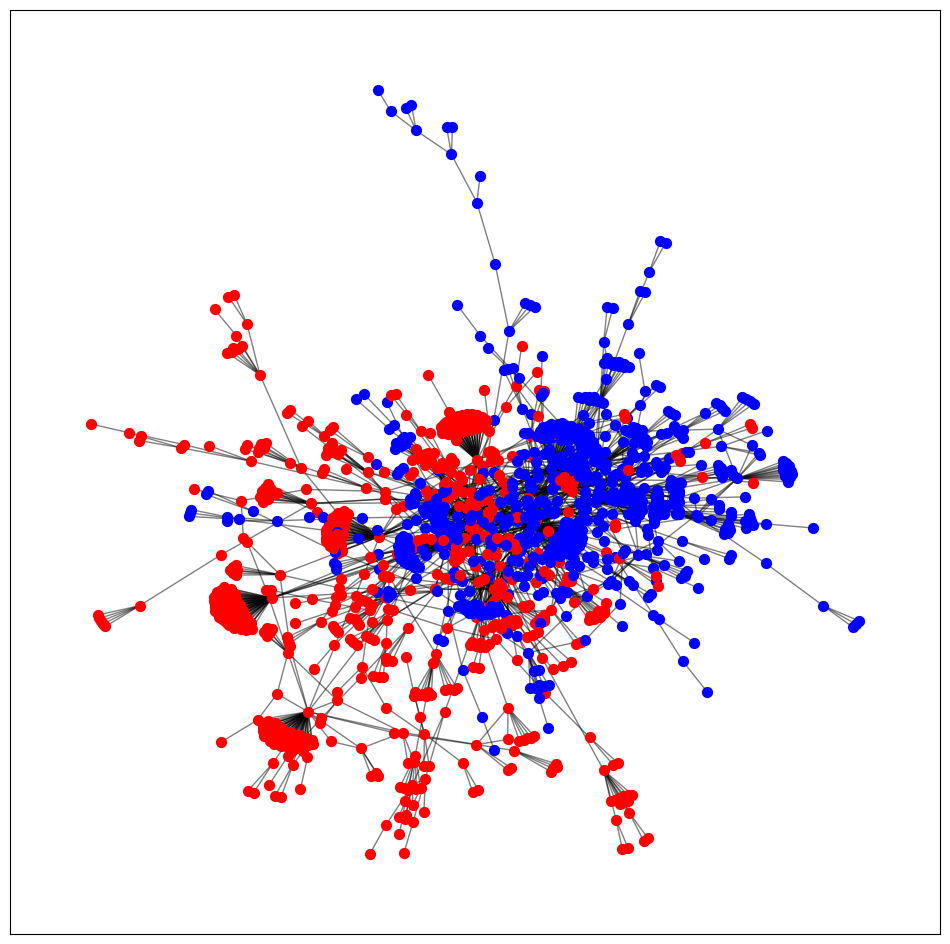

In [ ]:
#Partition and plot macroscale approach
G = nx.from_pandas_edgelist(dfq1, "username", "mentions")
datogliere=[]
for elem in G.nodes():
  if elem not in list(dfq1["username"]):
    datogliere.append(elem)
for elem in datogliere:
  G.remove_node(elem)
largest_cc = max(connected_components(G), key=len)
G_largest = G.subgraph(largest_cc).copy()
G_largest.remove_edges_from(nx.selfloop_edges(G_largest))
for (u, v) in G_largest.edges():
    G_largest.edges[u, v]['edge_weight_attr'] =1+(2-abs(dfq1.set_index("username").loc[u]["intervalsuser"]-dfq1.set_index("username").loc[v]["intervalsuser"]))
G_largestm = metis.networkx_to_metis(G_largest)
(edgecuts, parts) = metis.part_graph(G_largestm, 2)
colors = ['red', 'blue']
pos = nx.spring_layout(G_largest)
fig, ax = plt.subplots(figsize=(12, 12))
for i, node in enumerate(G_largest.nodes()):
    nx.draw_networkx_nodes(G_largest, pos, nodelist=[node], node_color=colors[parts[i]], node_size=50)
nx.draw_networkx_edges(G_largest, pos, alpha=0.5)
edge_labels = nx.get_edge_attributes(G_largest, 'weight')
nx.draw_networkx_edge_labels(G_largest, pos, edge_labels=edge_labels, font_size=8)
plt.show()

part1_nodes = [node for i, node in enumerate(G_largest.nodes()) if parts[i] == 0]
part2_nodes = [node for i, node in enumerate(G_largest.nodes()) if parts[i] == 1]

In [ ]:
#RWC
node_percentage = 0.3
number_simulations = 1000
get_rwc(G_largest, part1_nodes, part2_nodes, node_percentage, number_simulations)

0.7408999170095663

In [ ]:
calculate_arwc(G_largest, part1_nodes, part2_nodes, top_percentage=15)

<ipython-input-5-5e920c0685da>:5: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(graph).toarray()


0.8309002082011108

In [ ]:
displacement_random_walk(G_largest, part1_nodes, part2_nodes)

0.8665856622114204

In [ ]:
calculate_boundary_connectivity(G_largest, part1_nodes, part2_nodes)
bouncon=normalize(bouncon)

-0.15091646448259033

#Chatgpt Twitter

In [ ]:
chatgpt=pd.read_csv("/content/drive/MyDrive/Tesi Magistrale/Twitter Jan Mar.csv")

In [ ]:
chatgpt['month'] = chatgpt['date'].str.extract(r'-(\d{2})-')

In [ ]:
chatgpt[['mentions', 'cleaned_tweet']] = chatgpt['content'].apply(isolate_mentions).apply(pd.Series)
chatgpt['mentions'] = chatgpt['mentions'].apply(lambda x: [i for i in x if i.strip()])
chatgpt['cleaned_tweet'] = chatgpt['cleaned_tweet'].str.strip()

In [ ]:
chatgpt=chatgpt.explode("mentions")
chatgpt=chatgpt[chatgpt["mentions"].notnull()]

In [ ]:
chatgpt01=chatgpt[chatgpt["month"]=="01"]
chatgpt02=chatgpt[chatgpt["month"]=="02"]
chatgpt03=chatgpt[chatgpt["month"]=="03"]

In [ ]:
datogliere=[2,3]
chatgpt01=chatgpt01[chatgpt01["mentions"].isin(chatgpt01["username"].unique())]
while len(datogliere)!=0:
  datogliere=[]
  for elem in list(chatgpt01["mentions"].unique()):
    if elem not in list(chatgpt01["username"].unique()):
      datogliere.append(elem)
      chatgpt01=chatgpt01[~chatgpt01["mentions"].isin(datogliere)]

datogliere=[2,3]
chatgpt02=chatgpt02[chatgpt02["mentions"].isin(chatgpt02["username"].unique())]
while len(datogliere)!=0:
  datogliere=[]
  for elem in list(chatgpt02["mentions"].unique()):
    if elem not in list(chatgpt02["username"].unique()):
      datogliere.append(elem)
      chatgpt02=chatgpt02[~chatgpt02["mentions"].isin(datogliere)]

datogliere=[2,3]
chatgpt03=chatgpt03[chatgpt03["mentions"].isin(chatgpt03["username"].unique())]
while len(datogliere)!=0:
  datogliere=[]
  for elem in list(chatgpt03["mentions"].unique()):
    if elem not in list(chatgpt03["username"].unique()):
      datogliere.append(elem)
      chatgpt03=chatgpt03[~chatgpt03["mentions"].isin(datogliere)]

In [ ]:
chatgpt01['vader'] = chatgpt01["content"].apply(vader_score)
chatgpt02['vader'] = chatgpt02["content"].apply(vader_score)
chatgpt03['vader'] = chatgpt03["content"].apply(vader_score)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
sentiment1=chatgpt01[["username","vader"]].groupby("username",as_index=False).median()
sentiment1["intervals"]=sentiment1["vader"].apply(intervals)
dfq1=pd.merge(chatgpt01[["username","mentions"]],sentiment1,on="username")
dfq1=dfq1[dfq1["username"]!=dfq1["mentions"]]

sentiment2=chatgpt02[["username","vader"]].groupby("username",as_index=False).median()
sentiment2["intervals"]=sentiment2["vader"].apply(intervals)
dfq2=pd.merge(chatgpt02[["username","mentions"]],sentiment2,on="username")
dfq2=dfq2[dfq2["username"]!=dfq2["mentions"]]

sentiment3=chatgpt03[["username","vader"]].groupby("username",as_index=False).median()
sentiment3["intervals"]=sentiment3["vader"].apply(intervals)
dfq3=pd.merge(chatgpt03[["username","mentions"]],sentiment3,on="username")
dfq3=dfq3[dfq3["username"]!=dfq3["mentions"]]

In [ ]:
dfq1=dfq1.rename(columns={"vader":"vaderuser","intervals":"intervalsuser"})
dfq2=dfq2.rename(columns={"vader":"vaderuser","intervals":"intervalsuser"})
dfq3=dfq3.rename(columns={"vader":"vaderuser","intervals":"intervalsuser"})

In [ ]:
#microscale
a=pd.merge(dfq1,dfq1[["mentions","vaderuser","intervalsuser"]],left_on="username",right_on="mentions").drop(columns="mentions_y")
a[["vaderuser_x","vaderuser_y"]].corr()

,vaderuser_x,vaderuser_y
vaderuser_x,1.000000,0.066633
vaderuser_y,0.066633,1.000000


In [ ]:
a=pd.merge(dfq2,dfq2[["mentions","vaderuser","intervalsuser"]],left_on="username",right_on="mentions").drop(columns="mentions_y")
a[["vaderuser_x","vaderuser_y"]].corr()

,vaderuser_x,vaderuser_y
vaderuser_x,1.000000,0.054695
vaderuser_y,0.054695,1.000000


In [ ]:
a=pd.merge(dfq3,dfq3[["mentions","vaderuser","intervalsuser"]],left_on="username",right_on="mentions").drop(columns="mentions_y")
a[["vaderuser_x","vaderuser_y"]].corr()

,vaderuser_x,vaderuser_y
vaderuser_x,1.000000,0.147821
vaderuser_y,0.147821,1.000000


In [ ]:
#mesoscale
G,partition_result = process_graph(dfq1, username_col="username", mentions_col="mentions", intervals_col="intervalsuser")


Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'graph_tool', 'wurlitzer', 'leidenalg', 'bayanpy'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer', 'leidenalg'}


In [ ]:
communities=partition_result.communities
community_info = {}
for i, community in enumerate(communities, start=1):
    community_subgraph = G.subgraph(community).copy()
    num_nodes = community_subgraph.number_of_nodes()
    num_edges = community_subgraph.number_of_edges()
    community_nodes = list(community)
    community_info[i] = {'nodes': num_nodes, 'edges': num_edges, 'node_list': community_nodes}
for community, info in community_info.items():
    print(f"Community {community} has {info['nodes']} nodes and {info['edges']} edges.")
    print("Nodes:", info['node_list'])

Community 1 has 127 nodes and 1018 edges.
Nodes: ['gptroad', 'insightdottech', 'SoftClouds', 'LinhXuanTran_', 'blueb1rdtweet', 'albertogaruccio', 'adem_onar', 'FinMKTG', 'WSWMUC', 'MarshaCollier', 'IamAritraG', 'GlobalHoneyBee', '1OFFGINGER', 'Khulood_Almani', 'ocpalloneword2', 'Shi4Tech', 'stratorob', 'GuidoKerkhof', 'adelahafez', 'CryptoMStream', 'naullyn', 'dcallahan2', 'SiddharthKS', 'TechnoForeSight', 'KirkDBorne', 'FrRonconi', 'Fisheyebox', 'pratititech', 'louiseoconor', 'wavel_ai', 'SpirosMargaris', 'Analytics_659', 'citiesabc_', 'sherijenningsUN', 'psb_dc', 'MDBadhon001', 'Commetric', 'globaliqx', 'emlylabs', 'dinisguarda', 'pierrepinna', 'JimMarous', 'ArchimedesInte2', 'BillMew', 'AndrewinContact', 'ViRKL', 'BetaMoroney', 'nafisalam', 'TanyaSinha_', 'pierrecappelli', 'igniobydigitate', 'smaksked', 'HaroldSinnott', 'iCanizares', 'itsmuzza2004', 'enricomolinari', 'Eli_Krumova', 'KanezaDiane', 'Xbond49', 'anand_narang', 'digitalhealthxx', 'sbc111', 'HarbRimah', 'Corix_JC', 'Koves

In [ ]:
#purity
purity=[]
for elem in community_info[1]["node_list"]:
  purity.append(labels[elem]["l1"])
from collections import Counter
Counter(purity)

Counter({0: 66, 1: 61})

In [ ]:
purity=[]
for elem in community_info[3]["node_list"]:
  purity.append(labels[elem]["l1"])
from collections import Counter
Counter(purity)

Counter({1: 54, 0: 26})

In [ ]:
partition_result.conductance(summary=False)

[0.0902591599642538,
 0.1984126984126984,
 0.21991701244813278,
 0.19852941176470587,
 0.22826086956521738,
 0.2159090909090909,
 0.0990990990990991,
 0.16666666666666666,
 0.17355371900826447,
 0.15789473684210525,
 0.06521739130434782,
 0.08888888888888889,
 0.1450381679389313,
 0.023809523809523808,
 0.043478260869565216,
 0.034482758620689655,
 0.01818181818181818,
 0.01818181818181818,
 0.1724137931034483,
 0.04,
 0.05263157894736842,
 0.42857142857142855,
 0.2,
 0.15789473684210525,
 0.14285714285714285,
 0.2,
 0.3333333333333333,
 0.3333333333333333,
 0.5,
 0.2,
 0.2,
 0.6,
 0.3333333333333333,
 0.3333333333333333,
 0.6666666666666666,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.5,
 0.5,
 0.6,
 0.3333333333333333,
 0.3333333333333333,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

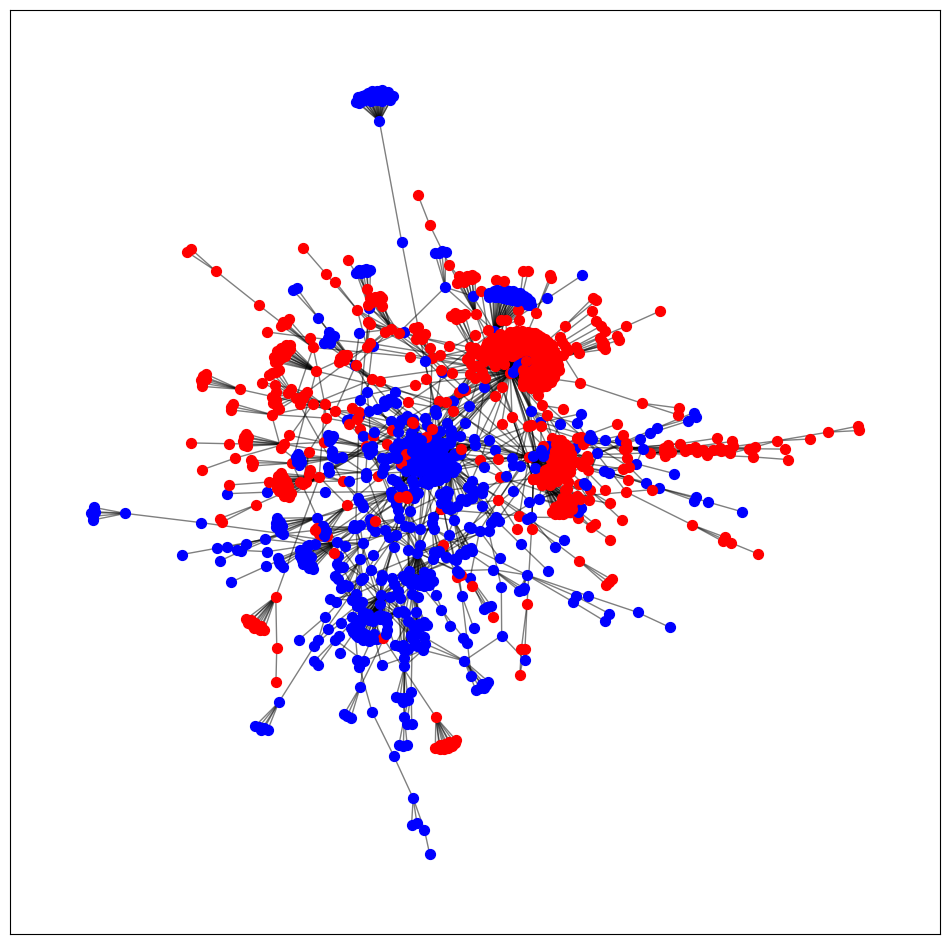

In [ ]:
#macroscale approach
G = nx.from_pandas_edgelist(dfq1, "username", "mentions")
datogliere=[]
for elem in G.nodes():
  if elem not in list(dfq1["username"]):
    datogliere.append(elem)
for elem in datogliere:
  G.remove_node(elem)

largest_cc = max(connected_components(G), key=len)
G_largest = G.subgraph(largest_cc).copy()

for (u, v) in G_largest.edges():
    G_largest.edges[u, v]['edge_weight_attr'] =1+(2-abs(dfq1.set_index("username").loc[u]["vaderuser"]-dfq1.set_index("username").loc[v]["vaderuser"])) # Puoi impostare i pesi a tuo piacimento

G_largestm = metis.networkx_to_metis(G_largest)
(edgecuts, parts) = metis.part_graph(G_largestm, 2)
colors = ['red', 'blue']
pos = nx.spring_layout(G_largest)
fig, ax = plt.subplots(figsize=(12, 12))
for i, node in enumerate(G_largest.nodes()):
    nx.draw_networkx_nodes(G_largest, pos, nodelist=[node], node_color=colors[parts[i]], node_size=50)
nx.draw_networkx_edges(G_largest, pos, alpha=0.5)
edge_labels = nx.get_edge_attributes(G_largest, 'weight')
nx.draw_networkx_edge_labels(G_largest, pos, edge_labels=edge_labels, font_size=8)
plt.show()

part1_nodes = [node for i, node in enumerate(G_largest.nodes()) if parts[i] == 0]
part2_nodes = [node for i, node in enumerate(G_largest.nodes()) if parts[i] == 1]


In [ ]:
node_percentage = 0.3
number_simulations = 1000
get_rwc(G_largest, part1_nodes, part2_nodes, node_percentage, number_simulations)

0.8896414660876433

In [ ]:
calculate_arwc(G_largest, part1_nodes, part2_nodes, top_percentage=15)

0.9660803863341464

In [ ]:
displacement_random_walk(G_largest, part1_nodes, part2_nodes)

0.9410191082802546

In [ ]:
calculate_boundary_connectivity(G_largest, part1_nodes, part2_nodes)
bouncon=normalize(bouncon)

0.1286798763643093

# Brexit Twitter

In [ ]:
antibrexit=pd.read_csv("/content/drive/MyDrive/Tesi Magistrale/TweetDataset_AntiBrexit_Jan-Mar2022.csv")
antibrexit["sentiment"]="AntiBrexit"
probrexit=pd.read_csv("/content/drive/MyDrive/Tesi Magistrale/TweetDataset_ProBrexit_Jan-Mar2022.csv")
probrexit["sentiment"]="ProBrexit"
brexit=pd.concat([antibrexit,probrexit])
brexit=brexit.drop_duplicates()

In [ ]:
brexit["month"]=brexit["Alternate Date Format"].str.extract(r"(\w+)")

In [ ]:
brexit[['mentions', 'cleaned_tweet']] = brexit['Hit Sentence'].apply(isolate_mentions).apply(pd.Series)
brexit['mentions'] = brexit['mentions'].apply(lambda x: [i for i in x if i.strip()])
brexit['cleaned_tweet'] = brexit['cleaned_tweet'].str.strip()

In [ ]:
brexit=brexit.explode("mentions")
brexit=brexit[brexit["mentions"].notnull()]
brexit["username"]=brexit["Influencer"].str.replace('@', '')

In [ ]:
brexit01=brexit[brexit["month"]=="Jan"]
brexit02=brexit[brexit["month"]=="Feb"]
brexit03=brexit[brexit["month"]=="Mar"]

In [ ]:
datogliere=[2,3]
brexit01=brexit01[brexit01["mentions"].isin(brexit01["username"].unique())]
while len(datogliere)!=0:
  datogliere=[]
  for elem in list(brexit01["mentions"].unique()):
    if elem not in list(brexit01["username"].unique()):
      datogliere.append(elem)
      brexit01=brexit01[~brexit01["mentions"].isin(datogliere)]

datogliere=[2,3]
brexit02=brexit02[brexit02["mentions"].isin(brexit02["username"].unique())]
while len(datogliere)!=0:
  datogliere=[]
  for elem in list(brexit02["mentions"].unique()):
    if elem not in list(brexit02["username"].unique()):
      datogliere.append(elem)
      brexit02=brexit02[~brexit02["mentions"].isin(datogliere)]

datogliere=[2,3]
brexit03=brexit03[brexit03["mentions"].isin(brexit03["username"].unique())]
while len(datogliere)!=0:
  datogliere=[]
  for elem in list(brexit03["mentions"].unique()):
    if elem not in list(brexit03["username"].unique()):
      datogliere.append(elem)
      brexit03=brexit03[~brexit03["mentions"].isin(datogliere)]

In [ ]:
sengen = brexit01.groupby('username')['sentiment'].agg(lambda x: x.mode().iat[0])
sengen_df = sengen.reset_index(name='most_frequent_sentiment')

senfeb = brexit02.groupby('username')['sentiment'].agg(lambda x: x.mode().iat[0])
senfeb_df = senfeb.reset_index(name='most_frequent_sentiment')

senmar = brexit03.groupby('username')['sentiment'].agg(lambda x: x.mode().iat[0])
senmar_df = senmar.reset_index(name='most_frequent_sentiment')

In [ ]:
dfq1=pd.merge(brexit01[["username","mentions"]],sengen_df,on="username")
dfq2=pd.merge(brexit02[["username","mentions"]],senfeb_df,on="username")
dfq3=pd.merge(brexit03[["username","mentions"]],senmar_df,on="username")

In [ ]:
dfq1=dfq1[dfq1["username"]!=dfq1["mentions"]]
dfq2=dfq2[dfq2["username"]!=dfq2["mentions"]]
dfq3=dfq3[dfq3["username"]!=dfq3["mentions"]]

In [ ]:
#microscale
a=pd.merge(dfq1,dfq1[["mentions","most_frequent_sentiment"]],left_on="username",right_on="mentions").drop(columns="mentions_y")
a=a.drop_duplicates()
len(a[a["most_frequent_sentiment_x"]==a["most_frequent_sentiment_y"]])/len(a)

0.8028107158541942

In [ ]:
a=pd.merge(dfq2,dfq2[["mentions","most_frequent_sentiment"]],left_on="username",right_on="mentions").drop(columns="mentions_y")
a=a.drop_duplicates()
len(a[a["most_frequent_sentiment_x"]==a["most_frequent_sentiment_y"]])/len(a)

0.7471929227628445

In [ ]:
a=pd.merge(dfq3,dfq3[["mentions","most_frequent_sentiment"]],left_on="username",right_on="mentions").drop(columns="mentions_y")
a=a.drop_duplicates()
len(a[a["most_frequent_sentiment_x"]==a["most_frequent_sentiment_y"]])/len(a)

0.7477656405163853

In [ ]:
#mesoscale
G, partition_result = process_graph(dfq1, username_col="username", mentions_col="mentions", intervals_col="most_frequent_sentiment")


In [ ]:
communities=partition_result.communities
community_info = {}

for i, community in enumerate(communities, start=1):
    community_subgraph = G.subgraph(community).copy()
    num_nodes = community_subgraph.number_of_nodes()
    num_edges = community_subgraph.number_of_edges()
    community_nodes = list(community)
    community_info[i] = {'nodes': num_nodes, 'edges': num_edges, 'node_list': community_nodes}
for community, info in community_info.items():
    print(f"Community {community} has {info['nodes']} nodes and {info['edges']} edges.")
    print("Nodes:", info['node_list'])

Community 1 has 688 nodes and 1521 edges.
Nodes: ['BrexitBin', 'Beany_1', 'Welshlass22', 'Twaterati911', 'sportmarketing1', 'g_gosden', 'Sillyshib', 'irenegarth1946', 'preacherous', 'PaulAllenSK1', 'roberthwo', 'LouisHenwood', 'Wigan2000', 'AndrewMathias5', 'florencerounda2', 'LucyElizabethH6', 'sally_steel_', 'snowleopardess', 'shimonagordon', 'Jackcdawes', 'murmuration94', 'ConnieFr', 'truby_sue', 'MikeJPretzel', 'CharlesTannock', 'gas2green', 'AlanNeil1010', 'LemSip27', 'steve20594431', 'civilwarghost_t', 'virgilone3', 'csav55', 'swillis100', 'valvebender', 'jcm247', 'harrismcannery1', 'MattProops', 'NeilMullens', 'neil_runkel', 'DixieRose100', 'Flic09', 'frogyuk', 'hay_jane', 'andrewcappesq', 'AndrewCappEsq', 'skirtbabe', 'jackcdawes', 'ShimonaGordon', 'LavertyCharles', 'Blockhead1011', 'StageBolter', 'ValueSurplus', 'nicklesby79', 'richardmurphyuk', 'groktrek', 'StopLyingUK', 'sirstan74', 'Cathbainsy123', '111meeuwis', 'farside1', 'swissbertie', 'Bob__Hudson', 'ClintClease', 'Apli

In [ ]:
partition_result.conductance(summary=False)

[0.055865921787709494,
 0.37406385494678757,
 0.4425,
 0.43813229571984436,
 0.5581395348837209,
 0.5,
 0.40522875816993464,
 0.5838926174496645,
 0.25,
 0.3333333333333333,
 1.0]

In [ ]:
#purity
purity=[]
for elem in community_info[1]["node_list"]:
  purity.append(labels[elem]["l1"])
from collections import Counter
Counter(purity)

Counter({'AntiBrexit': 652, 'ProBrexit': 36})

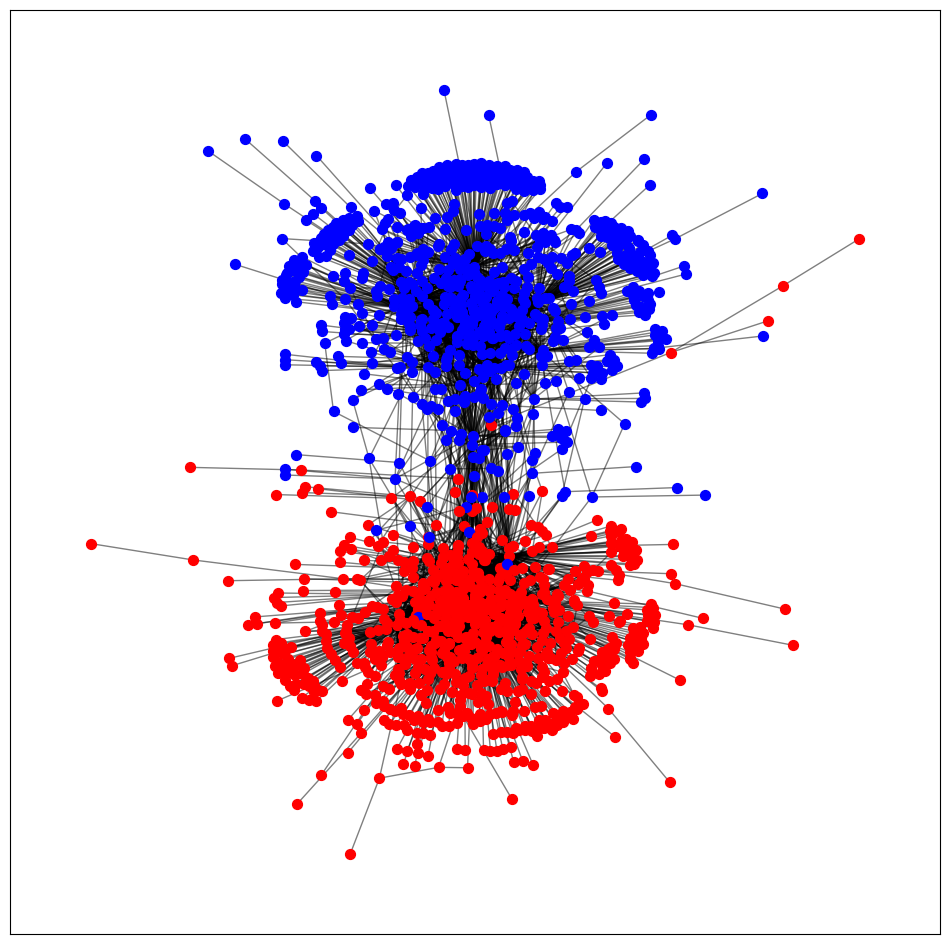

In [ ]:
#macroscale approach

G = nx.from_pandas_edgelist(dfq1, "username", "mentions")
datogliere=[]
for elem in G.nodes():
  if elem not in list(dfq1["username"]):
    datogliere.append(elem)
for elem in datogliere:
  G.remove_node(elem)

largest_cc = max(connected_components(G), key=len)
G_largest = G.subgraph(largest_cc).copy()

sentiment_dict = dfq1.set_index("username")["most_frequent_sentiment"].to_dict()

for (u, v) in G_largest.edges():
    if sentiment_dict[u] == sentiment_dict[v]:
        G_largest.edges[u, v]['edge_weight_attr'] = 2
    else:
        G_largest.edges[u, v]['edge_weight_attr'] = 1


G_largestm = metis.networkx_to_metis(G_largest)

(edgecuts, parts) = metis.part_graph(G_largestm, 2)
colors = ['red', 'blue']

pos = nx.spring_layout(G_largest)
fig, ax = plt.subplots(figsize=(12, 12))
#ax.set_title("Brexit Twitter Mar CY22",fontsize=20)
for i, node in enumerate(G_largest.nodes()):
    nx.draw_networkx_nodes(G_largest, pos, nodelist=[node], node_color=colors[parts[i]], node_size=50)
nx.draw_networkx_edges(G_largest, pos, alpha=0.5)
edge_labels = nx.get_edge_attributes(G_largest, 'weight')
nx.draw_networkx_edge_labels(G_largest, pos, edge_labels=edge_labels, font_size=8)

plt.show()

part1_nodes = [node for i, node in enumerate(G_largest.nodes()) if parts[i] == 0]
part2_nodes = [node for i, node in enumerate(G_largest.nodes()) if parts[i] == 1]


In [ ]:
node_percentage = 0.3
number_simulations = 1000
get_rwc(G_largest, part1_nodes, part2_nodes, node_percentage, number_simulations)

0.8434437283913878

In [ ]:
calculate_arwc(G_largest, part1_nodes, part2_nodes, top_percentage=15)

0.9096777710199402

In [ ]:
displacement_random_walk(G_largest, part1_nodes, part2_nodes)

0.9382111251580284

In [ ]:
calculate_boundary_connectivity(G_largest, part1_nodes, part2_nodes)
bouncon=normalize(bouncon)

-0.07798271806085784

# COVID Twitter

In [ ]:
labelled = pd.read_csv("/content/drive/MyDrive/Tesi Magistrale/covidlabelled.csv",sep=",")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Tesi Magistrale/covidlabelled.csv'

In [ ]:
conspiracy=labelled[labelled['labels'].str.contains('conspiracy|pharma', case=False) &  ~labelled['labels'].str.contains('political|side-effect', case=False)]
political=labelled[labelled["labels"].str.contains("political",case=False) & ~labelled['labels'].str.contains('conspiracy|pharma|side-effect', case=False)]
effects= labelled[labelled["labels"]=="side-effect"].head(1500)

In [ ]:
conspiracy["labels"]="conspiracy"
political["labels"]="political"
effects["labels"]="effects"
covidlabel=pd.concat([conspiracy,political,effects])

<ipython-input-24-ea127ae28eca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conspiracy["labels"]="conspiracy"
<ipython-input-24-ea127ae28eca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  political["labels"]="political"


In [ ]:
covidlabel["tweet"]=covidlabel["tweet"].apply(clean_tweet)
label_mapping = {
    'conspiracy': 0,
    'political': 1,
    'effects': 2
}

covidlabel['labels'] = covidlabel['labels'].map(label_mapping)

In [ ]:
train, test = train_test_split(covidlabel, test_size=0.2, random_state=42,stratify=covidlabel["labels"])

X_train = train['tweet']
y_train = train['labels']
X_test = test['tweet']
y_test = test['labels']


vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

clf = SVC(kernel='linear', random_state=42)
clf.fit(X_train_tfidf, y_train)

y_pred = clf.predict(X_test_tfidf)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

Accuracy: 0.7816793893129771
              precision    recall  f1-score   support

           0       0.73      0.83      0.78       261
           1       0.75      0.35      0.48        93
           2       0.84      0.87      0.85       301

    accuracy                           0.78       655
   macro avg       0.77      0.69      0.70       655
weighted avg       0.78      0.78      0.77       655



In [ ]:
covid2 = pd.read_csv("/content/drive/MyDrive/Tesi Magistrale/Covid-19 Twitter Dataset (Aug-Sep 2020).csv", encoding="latin")
covid1 = pd.read_csv("/content/drive/MyDrive/Tesi Magistrale/Covid-19 Twitter Dataset (Apr-Jun 2020).csv", encoding="latin")
covid3 = pd.read_csv("/content/drive/MyDrive/Tesi Magistrale/Covid-19 Twitter Dataset (Apr-Jun 2021).csv", encoding="latin")
covid1=covid1[covid1["lang"]=="en"]
covid2=covid2[covid2["lang"]=="en"]
covid3=covid3[covid3["lang"]=="en"]

In [ ]:
covid1=covid1[["original_author","original_text","compound","sentiment"]]
covid2=covid2[["original_author","original_text","compound","sentiment"]]
covid1=pd.concat([covid1,covid2])
covid3=covid3[["original_author","original_text","compound","sentiment"]]

In [ ]:
covid1[['mentions', 'cleaned_tweet']] = covid1['original_text'].apply(isolate_mentions).apply(pd.Series)
covid1['mentions'] = covid1['mentions'].apply(lambda x: [i for i in x if i.strip()])
covid1['cleaned_tweet'] = covid1['cleaned_tweet'].str.strip()

covid3[['mentions', 'cleaned_tweet']] = covid3['original_text'].apply(isolate_mentions).apply(pd.Series)
covid3['mentions'] = covid3['mentions'].apply(lambda x: [i for i in x if i.strip()])
covid3['cleaned_tweet'] = covid3['cleaned_tweet'].str.strip()

In [ ]:
covid1=covid1.explode("mentions")
covid1=covid1[covid1["mentions"].notnull()]
covid3=covid3.explode("mentions")
covid3=covid3[covid3["mentions"].notnull()]

In [ ]:
datogliere=[2,3]
covid1=covid1[covid1["mentions"].isin(covid1["original_author"].unique())]
while len(datogliere)!=0:
  datogliere=[]
  for elem in list(covid1["mentions"].unique()):
    if elem not in list(covid1["original_author"].unique()):
      datogliere.append(elem)
      covid1=covid1[~covid1["mentions"].isin(datogliere)]

datogliere=[2,3]
covid3=covid3[covid3["mentions"].isin(covid3["original_author"].unique())]
while len(datogliere)!=0:
  datogliere=[]
  for elem in list(covid3["mentions"].unique()):
    if elem not in list(covid3["original_author"].unique()):
      datogliere.append(elem)
      covid3=covid3[~covid3["mentions"].isin(datogliere)]


In [ ]:
X_covid1 = covid1['cleaned_tweet'].apply(clean_tweet)
X_covid1_tfidf1 = vectorizer.transform(X_covid1)
covid1_predictions1 = clf.predict(X_covid1_tfidf1)

X_covid3 = covid3['cleaned_tweet'].apply(clean_tweet)
X_covid3_tfidf3 = vectorizer.transform(X_covid3)
covid3_predictions3 = clf.predict(X_covid3_tfidf3)

covid1["topic"]=covid1_predictions1
covid3["topic"]=covid3_predictions3


In [ ]:
sen1 = covid1.groupby('original_author')['topic'].agg(lambda x: x.mode().iat[0])
sen1_df = sen1.reset_index(name='most_frequent_topic')

sen3 = covid3.groupby('original_author')['topic'].agg(lambda x: x.mode().iat[0])
sen3_df = sen3.reset_index(name='most_frequent_topic')

In [ ]:
dfq1=pd.merge(covid1[["original_author","mentions"]],sen1_df,on="original_author")
dfq3=pd.merge(covid3[["original_author","mentions"]],sen3_df,on="original_author")

In [ ]:
#microscale
a=pd.merge(dfq1,dfq1[["mentions","most_frequent_topic"]],left_on="original_author",right_on="mentions").drop(columns="mentions_y")
a=a.drop_duplicates()
len(a[a["most_frequent_topic_x"]==a["most_frequent_topic_y"]])/len(a)

0.7014384141182158

In [ ]:
a=pd.merge(dfq3,dfq3[["mentions","most_frequent_topic"]],left_on="original_author",right_on="mentions").drop(columns="mentions_y")
a=a.drop_duplicates()
len(a[a["most_frequent_topic_x"]==a["most_frequent_topic_y"]])/len(a)

0.7240204429301533

In [ ]:
#mesoscale
G, partition_result = process_graph(dfq1, username_col="original_author", mentions_col="mentions", intervals_col="most_frequent_topic")


Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'infomap', 'bayanpy', 'leidenalg', 'wurlitzer'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'leidenalg', 'wurlitzer'}


In [ ]:
communities=partition_result.communities
community_info = {}
for i, community in enumerate(communities, start=1):
    community_subgraph = G.subgraph(community).copy()
    num_nodes = community_subgraph.number_of_nodes()
    num_edges = community_subgraph.number_of_edges()
    community_nodes = list(community)
    community_info[i] = {'nodes': num_nodes, 'edges': num_edges, 'node_list': community_nodes}
for community, info in community_info.items():
    print(f"Community {community} has {info['nodes']} nodes and {info['edges']} edges.")
    print("Nodes:", info['node_list'])

Community 1 has 175 nodes and 202 edges.
Nodes: ['fishbluewill', 'Andrgilles1', 'marialves53', 'marieagregory', 'hossny_el', 'LetmastaZ', 'SebastienneL', 'ArgintieVulpe', 'el_mo_sa', 'Tita10218381', 'morinnaka', 'toyochanhanaga1', 'nine_stars5', 'Avargas2403', 'mhall55nine', 'INSTINC26289171', 'odoYKJXWJzAKcWl', 'gncsilva', 'petsnew1', 'Nada11970142', 'DanielDoebel', 'clyz95', 'EnzoKenzo10', 'ResitSahin14', 'rupali_rv', 'kokokarincyo', 'RosPalumbo71', 'nancyknowlton97', 'DogNaugty', 'pattucheenu', 'Amadeus510', 'Shahbaz_Nadir2', 'cdbda17582bf407', 'DannyVoglesong', 'bjewing2', 'Jilliemary', 'ele9061', 'sandi_joy', 'misoppachan', 'ibrahimacar5334', 'newworlddd555', 'AzzurraSilvy', 'Ritesh69571662', 'Lady_Jean25', 'KettyCrespoA', 'MonumentalTasks', 'StunEdgeYRC', 'Helenangel21', 'MAdeelIq', 'occasionalworry', 'akpolyme', 'april_mcmurtry', 'iamshathree', 'ekotro01', 'ma212424', 'SnowWhiteRina', 'Koruman_j', 'arv_katerina', 'B2VvemK5f8jJh3l', 'JHarris3000', 'Kali_Freedomto', 'Snishaa2', 's

In [ ]:
partition_result.conductance(summary=False)

[0.0380952380952381,
 0.2224622030237581,
 0.034482758620689655,
 0.11666666666666667,
 0.034482758620689655,
 0.08225108225108226,
 0.21374045801526717,
 0.11020408163265306,
 0.17293233082706766,
 0.01,
 0.05217391304347826,
 0.03954802259887006,
 0.022727272727272728,
 0.09574468085106383,
 0.07614213197969544,
 0.011627906976744186,
 0.08849557522123894,
 0.12994350282485875,
 0.02097902097902098,
 0.02127659574468085,
 0.01935483870967742,
 0.047619047619047616,
 0.0759493670886076,
 0.0718954248366013,
 0.028985507246376812,
 0.14084507042253522,
 0.047619047619047616,
 0.008849557522123894,
 0.02608695652173913,
 0.20300751879699247,
 0.07936507936507936,
 0.02912621359223301,
 0.1509433962264151,
 0.10891089108910891,
 0.06666666666666667,
 0.07865168539325842,
 0.10714285714285714,
 0.012048192771084338,
 0.045454545454545456,
 0.023809523809523808,
 0.08823529411764706,
 0.16049382716049382,
 0.03125,
 0.043478260869565216,
 0.011235955056179775,
 0.11475409836065574,
 0.0588

In [ ]:
#purity
purity=[]
for elem in community_info[1]["node_list"]:
  purity.append(labels[elem]["l1"])
from collections import Counter
Counter(purity)

Counter({0: 109, 2: 66})

In [ ]:
G = nx.from_pandas_edgelist(dfq1, "original_author", "mentions")
datogliere=[]
for elem in G.nodes():
  if elem not in list(dfq1["original_author"]):
    datogliere.append(elem)
for elem in datogliere:
  G.remove_node(elem)

largest_cc = max(connected_components(G), key=len)
G_largest = G.subgraph(largest_cc).copy()

G_largest.remove_edges_from(nx.selfloop_edges(G_largest))

sentiment_dict = dfq1.set_index("original_author")["most_frequent_topic"].to_dict()

for (u, v) in G_largest.edges():
    if sentiment_dict[u] == sentiment_dict[v]:
        G_largest.edges[u, v]['edge_weight_attr'] = 2
    else:
        G_largest.edges[u, v]['edge_weight_attr'] = 1

G_largestm = metis.networkx_to_metis(G_largest)

(edgecuts, parts) = metis.part_graph(G_largestm, 2)
colors = ['red', 'blue']

pos = nx.spring_layout(G_largest)

fig, ax = plt.subplots(figsize=(12, 12))
for i, node in enumerate(G_largest.nodes()):
    nx.draw_networkx_nodes(G_largest, pos, nodelist=[node], node_color=colors[parts[i]], node_size=50)
nx.draw_networkx_edges(G_largest, pos, alpha=0.5)
edge_labels = nx.get_edge_attributes(G_largest, 'weight')
nx.draw_networkx_edge_labels(G_largest, pos, edge_labels=edge_labels, font_size=8)
plt.show()

part1_nodes = [node for i, node in enumerate(G_largest.nodes()) if parts[i] == 0]
part2_nodes = [node for i, node in enumerate(G_largest.nodes()) if parts[i] == 1]

KeyboardInterrupt: 

In [ ]:
node_percentage = 0.3
number_simulations = 1000
get_rwc(G_largest, part1_nodes, part2_nodes, node_percentage, number_simulations)

In [ ]:
calculate_arwc(G_largest, part1_nodes, part2_nodes, top_percentage=15)

In [ ]:
displacement_random_walk(G_largest, part1_nodes, part2_nodes)

In [ ]:
calculate_boundary_connectivity(G_largest, part1_nodes, part2_nodes)
bouncon=normalize(bouncon)

NameError: name 'calculate_boundary_connectivity' is not defined

# Reddit chatgpt

In [ ]:
import pandas as pd
chatred=pd.read_csv("/content/drive/MyDrive/Tesi Magistrale/chatgptredditfinal.csv")

In [ ]:
chatred["year"]=pd.to_datetime(chatred["Comment_Date"]).dt.year
chatred["month"]=pd.to_datetime(chatred["Comment_Date"]).dt.month

In [ ]:
chatred['vaderparent'] = chatred["Parent_Text"].apply(vader_score)
chatred['vadercomm'] = chatred["Comment_Text"].apply(vader_score)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
chatred1=chatred[(chatred["year"]==2023) & (chatred["month"]==4)]
chatred2=chatred[(chatred["year"]==2023) & (chatred["month"]==5)]
chatred3=chatred[(chatred["year"]==2023) & (chatred["month"]==6)]

In [ ]:
chatredcom1=pd.concat([chatred1["Comment_Text"],chatred1["Parent_Text"]])
chatredcom2=pd.concat([chatred2["Comment_Text"],chatred2["Parent_Text"]])
chatredcom3=pd.concat([chatred3["Comment_Text"],chatred3["Parent_Text"]])

In [ ]:
#microscale
chatred1[["vaderparent","vadercomm"]].corr()

,vaderparent,vadercomm
vaderparent,1.000000,-0.019308
vadercomm,-0.019308,1.000000


In [ ]:
chatred2[["vaderparent","vadercomm"]].corr()

,vaderparent,vadercomm
vaderparent,1.000000,0.061724
vadercomm,0.061724,1.000000


In [ ]:
chatred3[["vaderparent","vadercomm"]].corr()

,vaderparent,vadercomm
vaderparent,1.000000,0.022194
vadercomm,0.022194,1.000000


In [ ]:
sentiment1=pd.concat([chatred1[["Parent_Author","vaderparent"]].rename(columns={"Parent_Author":"Author","vaderparent":"vader"}),chatred1[["Comment_Author","vadercomm"]].rename(columns={"Comment_Author":"Author","vadercomm":"vader"})])
sentiment1=sentiment1.groupby("Author").median()

In [ ]:
sentiment2=pd.concat([chatred2[["Parent_Author","vaderparent"]].rename(columns={"Parent_Author":"Author","vaderparent":"vader"}),chatred2[["Comment_Author","vadercomm"]].rename(columns={"Comment_Author":"Author","vadercomm":"vader"})])
sentiment2=sentiment2.groupby("Author").median()

In [ ]:
sentiment3=pd.concat([chatred3[["Parent_Author","vaderparent"]].rename(columns={"Parent_Author":"Author","vaderparent":"vader"}),chatred3[["Comment_Author","vadercomm"]].rename(columns={"Comment_Author":"Author","vadercomm":"vader"})])
sentiment3=sentiment3.groupby("Author").median()

In [ ]:
sentiment1["intervals"]=sentiment1["vader"].apply(intervals)
sentiment2["intervals"]=sentiment2["vader"].apply(intervals)
sentiment3["intervals"]=sentiment3["vader"].apply(intervals)

In [ ]:
#mesoscale
G, partition_result = process_graph(dfq1, username_col="Parent_Author", mentions_col="Comment_Author", intervals_col="intervals")


In [ ]:
partition_result.conductance(summary=False)

[0.21933085501858737,
 0.1864406779661017,
 0.045454545454545456,
 0.2,
 0.17647058823529413,
 0.17647058823529413,
 0.25,
 0.3333333333333333,
 0.3333333333333333,
 0.2,
 0.7142857142857143,
 0.5,
 0.5,
 0.3333333333333333,
 0.3333333333333333,
 0.5,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.5,
 0.3333333333333333,
 0.3333333333333333,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.3333333333333333,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

In [ ]:
communities=partition_result.communities
community_info = {}
for i, community in enumerate(communities, start=1):
    community_subgraph = G.subgraph(community).copy()
    num_nodes = community_subgraph.number_of_nodes()
    num_edges = community_subgraph.number_of_edges()
    community_nodes = list(community)
    community_info[i] = {'nodes': num_nodes, 'edges': num_edges, 'node_list': community_nodes}
for community, info in community_info.items():
    print(f"Community {community} has {info['nodes']} nodes and {info['edges']} edges.")
    print("Nodes:", info['node_list'])

Community 1 has 315 nodes and 315 edges.
Nodes: ['rich_awo', 'optimusklein357', 'op3rador', '7th_Spectrum', 'Skluff', 'MrYellowfield', 'Magnum2XXl', 'fallendiscrete', 'RayTrain', 'RainMakerJMR', 'Placid_Pelican', 'Raptor-ct7856', 'Athena_The_Funny', 'JJDude', 'bradrly', 'MatheusAlmeidasz', 'picklesareforever', 'dry_fappers_r_weird', 'droplivefred', 'Mighty_Lord6', 'blackp3dro', 'NG-Lightning007', 'ibx_toycat_iscool', 'Single-Benefit-3680', 'sheepare', 'Enough_Minimum_3708', 'testnetmainnet', 'jakeblonde005', 'dumbquestions903', 'vanguard3119', 'pentrical', 'imchocolatemilkman', 'pukhalapuka', 'Royal-Squash-3743', 'DoughHomer', 'masterap85', 'uRude', 'gargolito', 'Atoning_Unifex', 'Miguel_seonsaengnim', 'monkeyballpirate', 'MadManD3vi0us', 'AstralJumper', 'LeonidasSpacemanMD', 'CharlemagneAdelaar', 'inquestofknowledge', 'rsnydz13', 'MorseSource', 'Salkreath', 'FlanTamarind', 'rwb2406', 'pawsforlove', 'lsdtriopy540', 'RadleyCunningham', 'Datathrash', 'fullonsalad', 'SkywalkerTC', 'Gothda

In [ ]:
#purity
purity=[]
for elem in community_info[1]["node_list"]:
  purity.append(labels[elem]["l1"])
from collections import Counter
Counter(purity)

Counter({-1.0: 286, 1.0: 29})

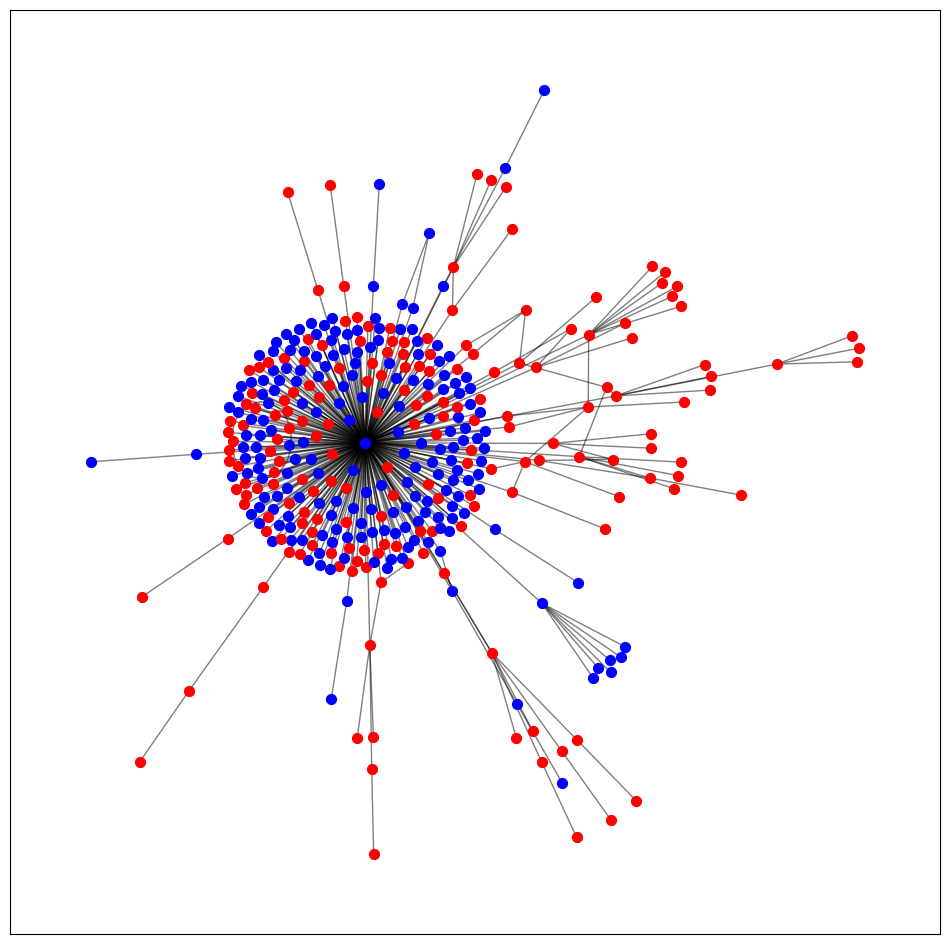

In [ ]:
#macroscale approach

G = nx.from_pandas_edgelist(chatred1.dropna(), "Parent_Author","Comment_Author")

largest_cc = max(connected_components(G), key=len)
G_largest = G.subgraph(largest_cc).copy()

for (u, v) in G_largest.edges():
    G_largest.edges[u, v]['edge_weight_attr'] =1+(2-abs(sentiment1.loc[u]["vader"]-sentiment1.loc[v]["vader"])) # Puoi impostare i pesi a tuo piacimento

G_largestm = metis.networkx_to_metis(G_largest)

(edgecuts, parts) = metis.part_graph(G_largestm, 2)
colors = ['red', 'blue']

pos = nx.spring_layout(G_largest)

fig, ax = plt.subplots(figsize=(12, 12))
for i, node in enumerate(G_largest.nodes()):
    nx.draw_networkx_nodes(G_largest, pos, nodelist=[node], node_color=colors[parts[i]], node_size=50)

nx.draw_networkx_edges(G_largest, pos, alpha=0.5)
edge_labels = nx.get_edge_attributes(G_largest, 'weight')
nx.draw_networkx_edge_labels(G_largest, pos, edge_labels=edge_labels, font_size=8)

plt.show()

part1_nodes = [node for i, node in enumerate(G_largest.nodes()) if parts[i] == 0]
part2_nodes = [node for i, node in enumerate(G_largest.nodes()) if parts[i] == 1]


In [ ]:
node_percentage = 0.3
number_simulations = 1000
get_rwc(G_largest, part1_nodes, part2_nodes, node_percentage, number_simulations)

0.171877498846081

In [ ]:
calculate_arwc(G_largest, part1_nodes, part2_nodes, top_percentage=15)

0.7710428052748137

In [ ]:
displacement_random_walk(G_largest, part1_nodes, part2_nodes)

0.6041666666666666

In [ ]:
calculate_boundary_connectivity(G_largest, part1_nodes, part2_nodes)

-0.39990715465237764

#Reddit vaccini

In [ ]:
vacred=pd.read_csv("/content/drive/MyDrive/Tesi Magistrale/vaccineredditfinal.csv")

In [ ]:
vacred["year"]=pd.to_datetime(vacred["Comment_Date"]).dt.year

In [ ]:
vacred['vaderparent'] = vacred["Parent_Text"].apply(vader_score)
vacred['vadercomm'] = vacred["Comment_Text"].apply(vader_score)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
vacred1=vacred[vacred["year"]==2022]
vacred2=vacred[vacred["year"]==2023]
vacred3=vacred[vacred["year"]==2024]

In [ ]:
vacredcom1=pd.concat([vacred1["Comment_Text"],vacred1["Parent_Text"]])
vacredcom2=pd.concat([vacred2["Comment_Text"],vacred2["Parent_Text"]])
vacredcom3=pd.concat([vacred3["Comment_Text"],vacred3["Parent_Text"]])


In [ ]:
#microscale
vacred1[["vaderparent","vadercomm"]].corr()

In [ ]:
vacred2[["vaderparent","vadercomm"]].corr()

In [ ]:
vacred3[["vaderparent","vadercomm"]].corr()

In [ ]:
sentiment1=pd.concat([vacred1[["Parent_Author","vaderparent"]].rename(columns={"Parent_Author":"Author","vaderparent":"vader"}),vacred1[["Comment_Author","vadercomm"]].rename(columns={"Comment_Author":"Author","vadercomm":"vader"})])
sentiment1=sentiment1.groupby("Author").median()

In [ ]:
sentiment2=pd.concat([vacred2[["Parent_Author","vaderparent"]].rename(columns={"Parent_Author":"Author","vaderparent":"vader"}),vacred2[["Comment_Author","vadercomm"]].rename(columns={"Comment_Author":"Author","vadercomm":"vader"})])
sentiment2=sentiment2.groupby("Author").median()

In [ ]:
sentiment3=pd.concat([vacred3[["Parent_Author","vaderparent"]].rename(columns={"Parent_Author":"Author","vaderparent":"vader"}),vacred3[["Comment_Author","vadercomm"]].rename(columns={"Comment_Author":"Author","vadercomm":"vader"})])
sentiment3=sentiment3.groupby("Author").median()

In [ ]:
sentiment1["intervals"]=sentiment1["vader"].apply(intervals)
sentiment2["intervals"]=sentiment2["vader"].apply(intervals)
sentiment3["intervals"]=sentiment3["vader"].apply(intervals)

In [ ]:
#mesoscale
G, partition_result = process_graph(dfq1, username_col="Parent_Author", mentions_col="Comment_Author", intervals_col="intervals")


In [ ]:
partition_result.conductance(summary=False)

In [ ]:
communities=partition_result.communities
community_info = {}
for i, community in enumerate(communities, start=1):
    community_subgraph = G.subgraph(community).copy()
    num_nodes = community_subgraph.number_of_nodes()
    num_edges = community_subgraph.number_of_edges()
    community_nodes = list(community)
    community_info[i] = {'nodes': num_nodes, 'edges': num_edges, 'node_list': community_nodes}
for community, info in community_info.items():
    print(f"Community {community} has {info['nodes']} nodes and {info['edges']} edges.")
    print("Nodes:", info['node_list'])

In [ ]:
#purity
purity=[]
for elem in community_info[2]["node_list"]:
  purity.append(labels[elem]["l1"])
from collections import Counter
Counter(purity)

In [ ]:
#macroscale
G = nx.from_pandas_edgelist(vacred1.dropna(), "Parent_Author","Comment_Author")
largest_cc = max(connected_components(G), key=len)
G_largest = G.subgraph(largest_cc).copy()
for (u, v) in G_largest.edges():
    G_largest.edges[u, v]['edge_weight_attr'] =1+(2-abs(sentiment1.loc[u]["vader"]-sentiment1.loc[v]["vader"]))
G_largestm = metis.networkx_to_metis(G_largest)
(edgecuts, parts) = metis.part_graph(G_largestm, 2)
colors = ['red', 'blue']
pos = nx.spring_layout(G_largest)
fig, ax = plt.subplots(figsize=(12, 12))
for i, node in enumerate(G_largest.nodes()):
    nx.draw_networkx_nodes(G_largest, pos, nodelist=[node], node_color=colors[parts[i]], node_size=50)
nx.draw_networkx_edges(G_largest, pos, alpha=0.5)
edge_labels = nx.get_edge_attributes(G_largest, 'weight')
nx.draw_networkx_edge_labels(G_largest, pos, edge_labels=edge_labels, font_size=8)

plt.show()

part1_nodes = [node for i, node in enumerate(G_largest.nodes()) if parts[i] == 0]
part2_nodes = [node for i, node in enumerate(G_largest.nodes()) if parts[i] == 1]


In [ ]:
node_percentage = 0.3
number_simulations = 1000
get_rwc(G_largest, part1_nodes, part2_nodes, node_percentage, number_simulations)

In [ ]:
calculate_arwc(G_largest, part1_nodes, part2_nodes, top_percentage=15)

In [ ]:
displacement_random_walk(G_largest, part1_nodes, part2_nodes)

In [ ]:
calculate_boundary_connectivity(G_largest, part1_nodes, part2_nodes)
bouncon


# Reddit covid

In [ ]:
covidred=pd.read_csv("/content/drive/MyDrive/Tesi Magistrale/covidredditfinal.csv")
covidred2=pd.read_csv("/content/drive/MyDrive/Tesi Magistrale/covidredditfinal2.csv")
covidred=pd.concat([covidred,covidred2])

In [ ]:
covidred["year"]=pd.to_datetime(covidred["Comment_Date"]).dt.year
covidred["month"]=pd.to_datetime(covidred["Comment_Date"]).dt.month

In [ ]:
covidred['vaderparent'] = covidred["Parent_Text"].apply(vader_score)
covidred['vadercomm'] = covidred["Comment_Text"].apply(vader_score)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
X_covidpar = covidred['Parent_Text'].apply(clean_tweet)
X_covidpar_tfidf = vectorizer.transform(X_covidpar)
covidpar_predictions = clf.predict(X_covidpar_tfidf)

X_covidcom = covidred['Comment_Text'].apply(clean_tweet)
X_covidcom_tfidf = vectorizer.transform(X_covidcom)
covidcom_predictions = clf.predict(X_covidcom_tfidf)


covidred["topicparent"]=covidpar_predictions
covidred["topiccomment"]=covidcom_predictions

In [ ]:
covidred1=covidred[covidred["year"]==2020]
covidred2=covidred[covidred["year"]==2021]

In [ ]:
covidredcom1=pd.concat([covidred1["Comment_Text"],covidred1["Parent_Text"]])
covidredcom2=pd.concat([covidred2["Comment_Text"],covidred2["Parent_Text"]])

In [ ]:
sentiment1=pd.concat([covidred1[["Parent_Author","topicparent"]].rename(columns={"Parent_Author":"Author","topicparent":"topic"}),covidred1[["Comment_Author","topiccomment"]].rename(columns={"Comment_Author":"Author","topiccomment":"topic"})])
sengen = sentiment1.groupby('Author')['topic'].agg(lambda x: x.mode().iat[0])
sengen_df1 = sengen.reset_index(name='most_frequent_topic').set_index("Author")

sentiment2=pd.concat([covidred2[["Parent_Author","topicparent"]].rename(columns={"Parent_Author":"Author","topicparent":"topic"}),covidred2[["Comment_Author","topiccomment"]].rename(columns={"Comment_Author":"Author","topiccomment":"topic"})])
sengen = sentiment2.groupby('Author')['topic'].agg(lambda x: x.mode().iat[0])
sengen_df2 = sengen.reset_index(name='most_frequent_topic').set_index("Author")

In [ ]:
# microscale
len(covidred1[covidred1["topicparent"]==covidred1["topiccomment"]])/len(covidred1)

0.4888535031847134

In [ ]:
len(covidred2[covidred2["topicparent"]==covidred2["topiccomment"]])/len(covidred2)

0.4927797833935018

In [ ]:
#mesoscale
G, partition_result = process_graph(dfq1, username_col="Parent_Author", mentions_col="Comment_Author", intervals_col="modt_frequent_topic")


In [ ]:
partition_result.conductance(summary=False)

[0.15294117647058825,
 0.2542372881355932,
 0.20833333333333334,
 0.41818181818181815,
 0.24,
 0.21052631578947367,
 0.1875,
 0.1724137931034483,
 0.2903225806451613,
 0.18518518518518517,
 0.17647058823529413,
 0.2727272727272727,
 0.3333333333333333,
 0.2,
 0.5,
 0.2,
 0.5555555555555556,
 0.6,
 0.3333333333333333,
 0.3333333333333333,
 0.7142857142857143,
 0.3333333333333333,
 0.8,
 0.5,
 0.3333333333333333,
 0.6666666666666666,
 0.6,
 0.3333333333333333,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [ ]:
communities=partition_result.communities
community_info = {}
for i, community in enumerate(communities, start=1):
    community_subgraph = G.subgraph(community).copy()
    num_nodes = community_subgraph.number_of_nodes()
    num_edges = community_subgraph.number_of_edges()
    community_nodes = list(community)
    community_info[i] = {'nodes': num_nodes, 'edges': num_edges, 'node_list': community_nodes}
for community, info in community_info.items():
    print(f"Community {community} has {info['nodes']} nodes and {info['edges']} edges.")
    print("Nodes:", info['node_list'])

Community 1 has 31 nodes and 36 edges.
Nodes: ['xcubedycubed', 'KuduIO', 'jokes_on_you', 'dankhorse25', 'Traditional-Level-96', 'THVAQLJZawkw8iCKEZAE', 'erbazzone', 'aziridine86', 'MyStatusIsTheBaddest', 'Max_Thunder', 'ilessthanthreekarate', 'Imposter24', 'BobbleHeadBryant', 'Inmyprime-', 'redditgirlwz', 'RussianEntrepreneur', 'Trinkitt', 'Sugarisadog', 'joeco316', 'Substantial_Fail', 'tasunder', 'churukah', 'anon_adderlan', 'syntheticassault', 'jeffzebub', 'Enragedwasp101', 'Bbgun371', 'large_pp_smol_brain', 'GORbyBE', 'throwaway9728_', 'SoItWasYouAllAlong']
Community 2 has 22 nodes and 22 edges.
Nodes: ['Yefref', 'helm', 'Cute_Parfait_2182', 'RagingNerdaholic', 'zonadedesconforto', 'rzet', 'Pickleballer23', 'Forsaken_Rooster_365', 'historicalginger', 'Dragon_Maister', 'TheOmeletteOfDisease', 'boooooooooo_cowboys', 'thewaiting28', 'traveler19395', 'corruptedchick', 'pixel_of_moral_decay', 'Bluest_waters', 'hughk', 'Donkey_KongGold03', 'CobradordelFrac', 'bcbill', 'DukeMo']
Community 

In [ ]:
#purity
purity=[]
for elem in community_info[3]["node_list"]:
  purity.append(labels[elem]["l1"])
from collections import Counter
Counter(purity)

Counter({0: 4, 2: 14, 1: 2})

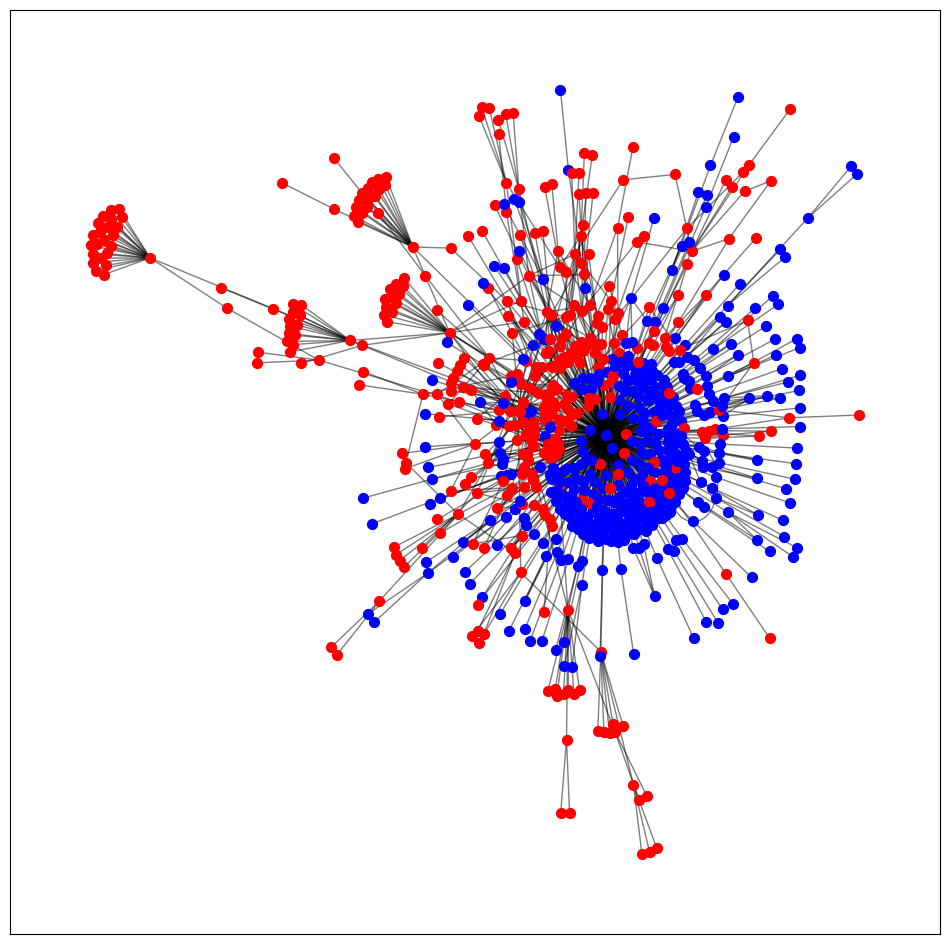

In [ ]:
#macroscale

G = nx.from_pandas_edgelist(covidred1.dropna(), "Parent_Author","Comment_Author")

largest_cc = max(connected_components(G), key=len)
G_largest = G.subgraph(largest_cc).copy()

sentiment_dict = sengen_df1["most_frequent_topic"].to_dict()
for (u, v) in G_largest.edges():
    if sentiment_dict[u] == sentiment_dict[v]:
        G_largest.edges[u, v]['edge_weight_attr'] = 2
    else:
        G_largest.edges[u, v]['edge_weight_attr'] = 1

G_largestm = metis.networkx_to_metis(G_largest)

(edgecuts, parts) = metis.part_graph(G_largestm, 2)
colors = ['red', 'blue']
pos = nx.spring_layout(G_largest)
fig, ax = plt.subplots(figsize=(12, 12))
for i, node in enumerate(G_largest.nodes()):
    nx.draw_networkx_nodes(G_largest, pos, nodelist=[node], node_color=colors[parts[i]], node_size=50)
nx.draw_networkx_edges(G_largest, pos, alpha=0.5)
edge_labels = nx.get_edge_attributes(G_largest, 'weight')
nx.draw_networkx_edge_labels(G_largest, pos, edge_labels=edge_labels, font_size=8)
plt.show()

part1_nodes = [node for i, node in enumerate(G_largest.nodes()) if parts[i] == 0]
part2_nodes = [node for i, node in enumerate(G_largest.nodes()) if parts[i] == 1]


In [ ]:
node_percentage = 0.3
number_simulations = 1000
get_rwc(G_largest, part1_nodes, part2_nodes, node_percentage, number_simulations)

0.444015656823448

In [ ]:
calculate_arwc(G_largest, part1_nodes, part2_nodes, top_percentage=15)

0.8960326174487817

In [ ]:
displacement_random_walk(G_largest, part1_nodes, part2_nodes)

0.7650727650727654

In [ ]:
calculate_boundary_connectivity(G_largest, part1_nodes, part2_nodes)
bouncon=normalize(bouncon)


-0.028230913417827755

#Brexit Reddit

In [ ]:
brexitred=pd.read_csv("/content/drive/MyDrive/Tesi Magistrale/brexitredditfinal.csv")

NameError: name 'pd' is not defined

In [ ]:
brexit=pd.concat([brexit[brexit["sentiment"]=="AntiBrexit"].head(5000),
brexit[brexit["sentiment"]=="ProBrexit"].head(5000)])
df = brexit[["cleaned_tweet", "sentiment"]]
df["sentiment"] = df["sentiment"].apply(lambda x: 1 if x == 'AntiBrexit' else 0)
df['cleaned_tweet'] = df['cleaned_tweet'].apply(clean_tweet)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state=42,stratify=df["sentiment"])

X_train = train['cleaned_tweet']
y_train = train['sentiment']
X_test = test['cleaned_tweet']
y_test = test['sentiment']

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

clf = AdaBoostClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))


Accuracy: 0.91
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1000
           1       0.92      0.90      0.91      1000

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



In [ ]:
brexitred['Comment_Text'] = brexitred['Comment_Text'].apply(clean_tweet)
brexitred['Parent_Text'] = brexitred['Parent_Text'].apply(clean_tweet)
X_brexred1 = brexitred['Comment_Text']
X_brexred_tfidf1 = vectorizer.transform(X_brexred1)
brexred_predictions1 = clf.predict(X_brexred_tfidf1)
X_brexred2 = brexitred['Parent_Text']
X_brexred_tfidf2 = vectorizer.transform(X_brexred2)
brexred_predictions2 = clf.predict(X_brexred_tfidf2)
brexitred['Parent_sentiment'] = brexred_predictions2
brexitred['Comment_sentiment'] = brexred_predictions1

In [ ]:
brexitred["Parent_sentiment"] = brexitred["Parent_sentiment"].apply(lambda x: "AntiBrexit" if x == 1 else "ProBrexit")
brexitred["Comment_sentiment"] = brexitred["Comment_sentiment"].apply(lambda x: "AntiBrexit" if x == 1 else "ProBrexit")

In [ ]:
brexitred["year"]=pd.to_datetime(brexitred["Comment_Date"]).dt.year

In [ ]:
brexitred["month"]=pd.to_datetime(brexitred["Comment_Date"]).dt.month

In [ ]:
brexitred1=brexitred[brexitred["year"]<=2022]
brexitred2=brexitred[brexitred["year"]==2023]
brexitred3=brexitred[brexitred["year"]==2024]

In [ ]:
brexitredcom1=pd.concat([brexitred1["Comment_Text"],brexitred1["Parent_Text"]])
brexitredcom2=pd.concat([brexitred2["Comment_Text"],brexitred2["Parent_Text"]])
brexitredcom3=pd.concat([brexitred2["Comment_Text"],brexitred2["Parent_Text"]])

In [ ]:
sentiment1=pd.concat([brexitred1[["Parent_Author","Parent_sentiment"]].rename(columns={"Parent_Author":"Author","Parent_sentiment":"sentiment"}),brexitred1[["Comment_Author","Comment_sentiment"]].rename(columns={"Comment_Author":"Author","Comment_sentiment":"sentiment"})])
sengen = sentiment1.groupby('Author')['sentiment'].agg(lambda x: x.mode().iat[0])
sengen_df1 = sengen.reset_index(name='most_frequent_sentiment').set_index("Author")

sentiment2=pd.concat([brexitred2[["Parent_Author","Parent_sentiment"]].rename(columns={"Parent_Author":"Author","Parent_sentiment":"sentiment"}),brexitred2[["Comment_Author","Comment_sentiment"]].rename(columns={"Comment_Author":"Author","Comment_sentiment":"sentiment"})])
sengen = sentiment2.groupby('Author')['sentiment'].agg(lambda x: x.mode().iat[0])
sengen_df2 = sengen.reset_index(name='most_frequent_sentiment').set_index("Author")

sentiment3=pd.concat([brexitred3[["Parent_Author","Parent_sentiment"]].rename(columns={"Parent_Author":"Author","Parent_sentiment":"sentiment"}),brexitred3[["Comment_Author","Comment_sentiment"]].rename(columns={"Comment_Author":"Author","Comment_sentiment":"sentiment"})])
sengen = sentiment3.groupby('Author')['sentiment'].agg(lambda x: x.mode().iat[0])
sengen_df3 = sengen.reset_index(name='most_frequent_sentiment').set_index("Author")

In [ ]:
#microscale
len(brexitred1[brexitred1["Parent_sentiment"]==brexitred1["Comment_sentiment"]])/len(brexitred1)

0.4738317757009346

In [ ]:
len(brexitred2[brexitred2["Parent_sentiment"]==brexitred2["Comment_sentiment"]])/len(brexitred2)

0.4718361375274323

In [ ]:
len(brexitred3[brexitred3["Parent_sentiment"]==brexitred3["Comment_sentiment"]])/len(brexitred3)

0.5579831932773109

In [ ]:
#mesoscale
G, partition_result = process_graph(dfq1, username_col="Parent_Author", mentions_col="Comment_Author", intervals_col="most_frequent_sentiment")

In [ ]:
partition_result.conductance(summary=False)

[0.12663755458515283,
 0.17647058823529413,
 0.12222222222222222,
 0.4462809917355372,
 0.18012422360248448,
 0.10679611650485436,
 0.29411764705882354,
 0.09090909090909091,
 0.25,
 0.10526315789473684,
 0.17647058823529413,
 0.2413793103448276,
 0.3,
 0.14285714285714285,
 0.2,
 0.6666666666666666,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.5,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.5,
 0.3333333333333333,
 0.3333333333333333,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1

In [ ]:
communities=partition_result.communities
community_info = {}
for i, community in enumerate(communities, start=1):
    community_subgraph = G.subgraph(community).copy()
    num_nodes = community_subgraph.number_of_nodes()
    num_edges = community_subgraph.number_of_edges()
    community_nodes = list(community)
    community_info[i] = {'nodes': num_nodes, 'edges': num_edges, 'node_list': community_nodes}
for community, info in community_info.items():
    print(f"Community {community} has {info['nodes']} nodes and {info['edges']} edges.")
    print("Nodes:", info['node_list'])

Community 1 has 84 nodes and 100 edges.
Nodes: ['Versidious', 'IceColdWasabi', 'Independent_Pear_429', 'DontWannaSayMyName', 'vbrimme', 'kalekayn', 'nonamethxagain', 'Entire-Ranger323', 'kwan_e', 'panzerbjrn', 'ptvlm', 'D0hB0yz', 'Lukensz', 'L_James', 'execilue', 'CptDropbear', 'GhostRappa95', 'StiCkSt1ckLy', 'cg12983', 'karlhungusjr', 'Far-Policy-8589', 'Squidking1000', 'PeteAH', 'RichardBreecher', 'ArcticISAF', 'RustyNewWrench', 'turbo_fried_chicken', 'romacopia', 'spectacletourette', 'Giblette101', 'Inspect1234', 'StevInPitt', 'Z3t4', 'Shikimori_Inosuke', 'takethecorner', 'Fit-Virus-7056', 'Dark_Ansem', 'doomladen', 'Delicious_MilkSteak', 'Informal_Self_5671', 'ApolloMac', 'hwc000000', 'Gilgamesh034', 'MattGdr', 'Scotto6UK', 'DutchDispair', 'daschande', 'Apprehensive_Bug_826', 'BrownSugarBare', 'ariesangel0329', 'david-writers', 'Andross_Darkheart', 'firstfloor27', 'Rippthrough', 'formerly_gruntled', 'Infernalism', 'spoobles', 'KingofFlukes', 'Jackpot777', 'canada432', 'mackavicious

In [ ]:
#purity
purity=[]
for elem in community_info[2]["node_list"]:
  purity.append(labels[elem]["l1"])
from collections import Counter
Counter(purity)

Counter({'ProBrexit': 23, 'AntiBrexit': 48})

In [ ]:
#macroscale
G = nx.from_pandas_edgelist(brexitred1.dropna(), "Parent_Author","Comment_Author")
largest_cc = max(connected_components(G), key=len)
G_largest = G.subgraph(largest_cc).copy()
sentiment_dict = sengen_df1["most_frequent_sentiment"].to_dict()

for (u, v) in G_largest.edges():
    if sentiment_dict[u] == sentiment_dict[v]:
        G_largest.edges[u, v]['edge_weight_attr'] = 2
    else:
        G_largest.edges[u, v]['edge_weight_attr'] = 1


G_largestm = metis.networkx_to_metis(G_largest)

(edgecuts, parts) = metis.part_graph(G_largestm, 2)
colors = ['red', 'blue']

pos = nx.spring_layout(G_largest)

fig, ax = plt.subplots(figsize=(12, 12))
for i, node in enumerate(G_largest.nodes()):
    nx.draw_networkx_nodes(G_largest, pos, nodelist=[node], node_color=colors[parts[i]], node_size=50)

nx.draw_networkx_edges(G_largest, pos, alpha=0.5)
edge_labels = nx.get_edge_attributes(G_largest, 'weight')
nx.draw_networkx_edge_labels(G_largest, pos, edge_labels=edge_labels, font_size=8)

plt.show()

part1_nodes = [node for i, node in enumerate(G_largest.nodes()) if parts[i] == 0]
part2_nodes = [node for i, node in enumerate(G_largest.nodes()) if parts[i] == 1]

In [ ]:
node_percentage = 0.3
number_simulations = 1000
get_rwc(G_largest, part1_nodes, part2_nodes, node_percentage, number_simulations)

0.5493750643612882

In [ ]:
calculate_arwc(G_largest, part1_nodes, part2_nodes, top_percentage=15)

0.9157990590702325

In [ ]:
displacement_random_walk(G_largest, part1_nodes, part2_nodes)

0.8101374570446738

In [ ]:
calculate_boundary_connectivity(G_largest, part1_nodes, part2_nodes)
bouncon=normalize(bouncon)

-0.19571699079108323